In [1]:
pip install tensorflow scikit-learn pillow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np 
import random 
from PIL import Image, ImageEnhance 

In [3]:
# Keras / TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# Sklearn
from sklearn.utils import shuffle


In [4]:
train_dir = "MRI_images/Training"
test_dir  = "MRI_images/Testing"


In [5]:
from sklearn.utils import shuffle
import os

# ===============================
# Load and shuffle TRAIN data
# ===============================
train_paths = []
train_labels = []

for label in sorted(os.listdir(train_dir)):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

# ===============================
# Load and shuffle TEST data
# ===============================
test_paths = []
test_labels = []

for label in sorted(os.listdir(test_dir)):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)


DATA VISUALIZATION:

In [6]:
#taking random image index for  

import random 
import matplotlib.pyplot as plt

#select random indices for 10 images 

random_indices = random.sample(range(len(train_paths)),10)
random_indices

[401, 2616, 3078, 1998, 4738, 3159, 1443, 317, 5402, 5296]

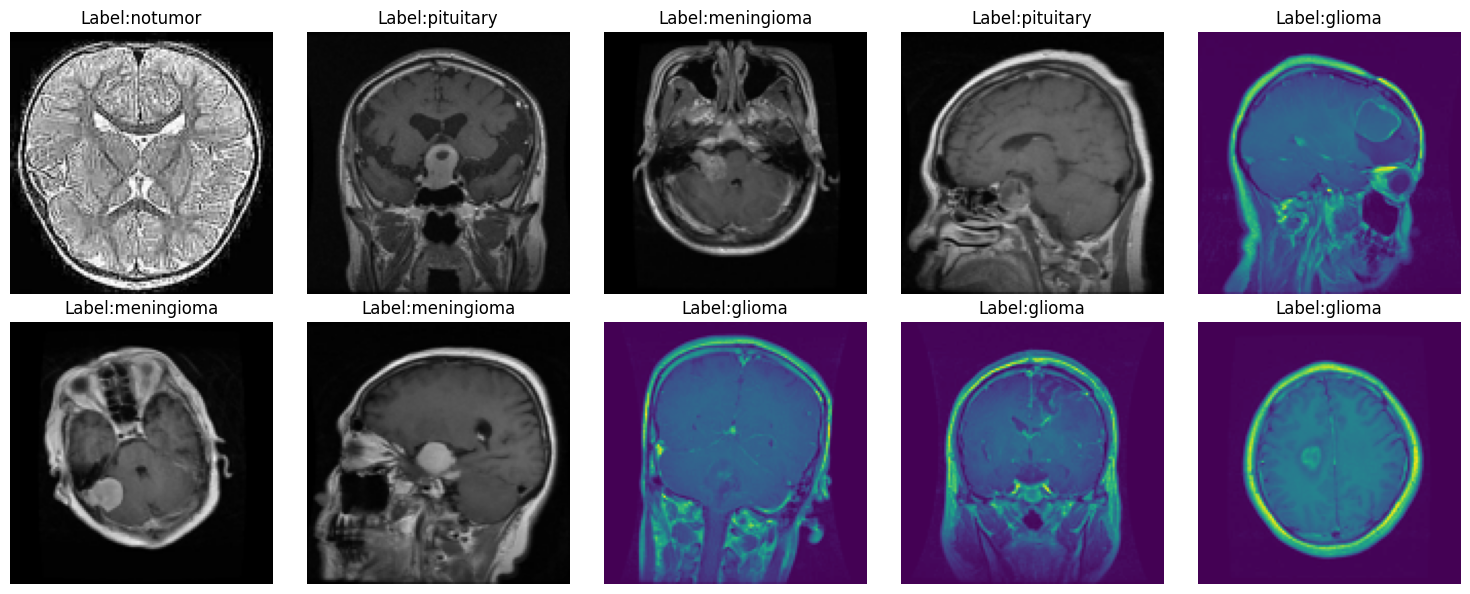

In [7]:
# Image processing / visualization
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))

    # Display image
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label:{train_labels[idx]}")

plt.tight_layout()
plt.show()


IMAGE PREPROCESSING

In [9]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [10]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 177s 617ms/step - loss: 0.4401 - sparse_categorical_accuracy: 0.8296
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 168s 589ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9120
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 179s 629ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.9438
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 179s 629ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9575
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 171s 601ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9619


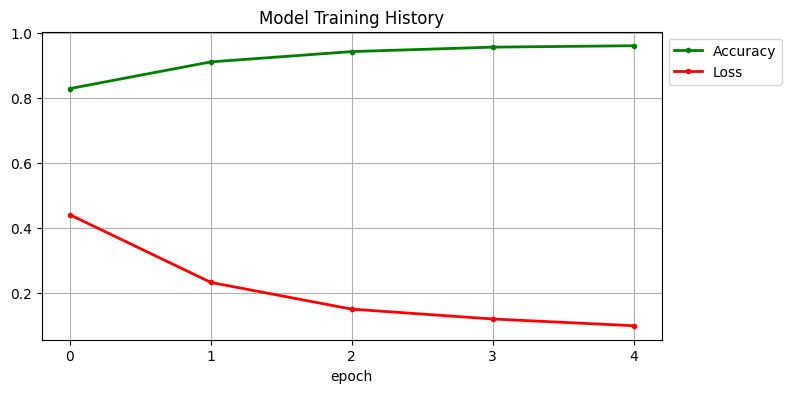

In [11]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
# ===============================
# Imports
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# ===============================
# Generate predictions on test data
# ===============================

# Load test images
test_images = open_images(test_paths)

# Encode test labels (FIXED function name)
test_labels_encoded = encode_label(test_labels)

# Predict
test_predictions = model.predict(test_images)

# Convert probabilities to predicted class indices
test_pred_classes = np.argmax(test_predictions, axis=1)

# ===============================
# Classification Report
# ===============================
print("Classification Report:")
print(
    classification_report(
        test_labels_encoded,
        test_pred_classes
    )
)


41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 638ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       300
           1       0.95      0.87      0.91       306
           2       0.99      1.00      0.99       405
           3       0.96      0.98      0.97       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[288  11   0   1]
 [ 24 267   5  10]
 [  2   0 403   0]
 [  2   3   0 295]]


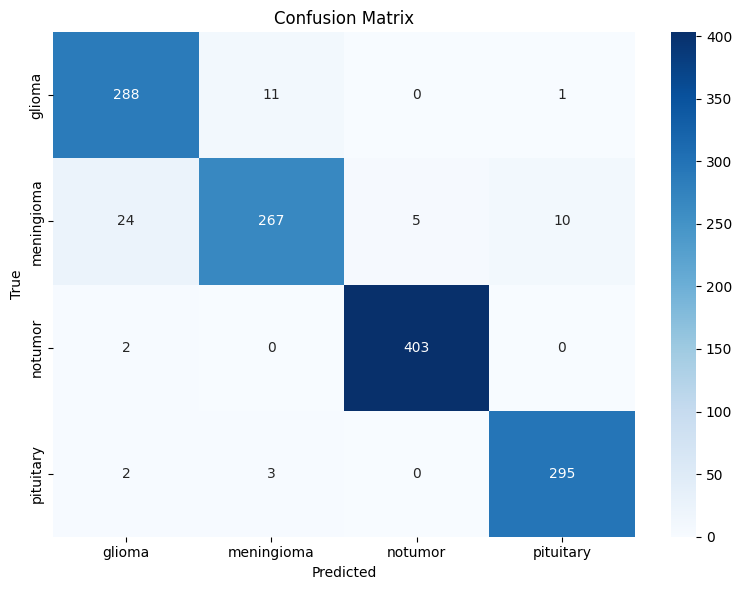

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ===============================
# Generate Confusion Matrix
# ===============================

conf_matrix = confusion_matrix(
    test_labels_encoded,
    np.argmax(test_predictions, axis=1)
)

print("Confusion Matrix:")
print(conf_matrix)

# ===============================
# Plot Confusion Matrix
# ===============================

plt.figure(figsize=(8, 6))

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=os.listdir(train_dir),
    yticklabels=os.listdir(train_dir)
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


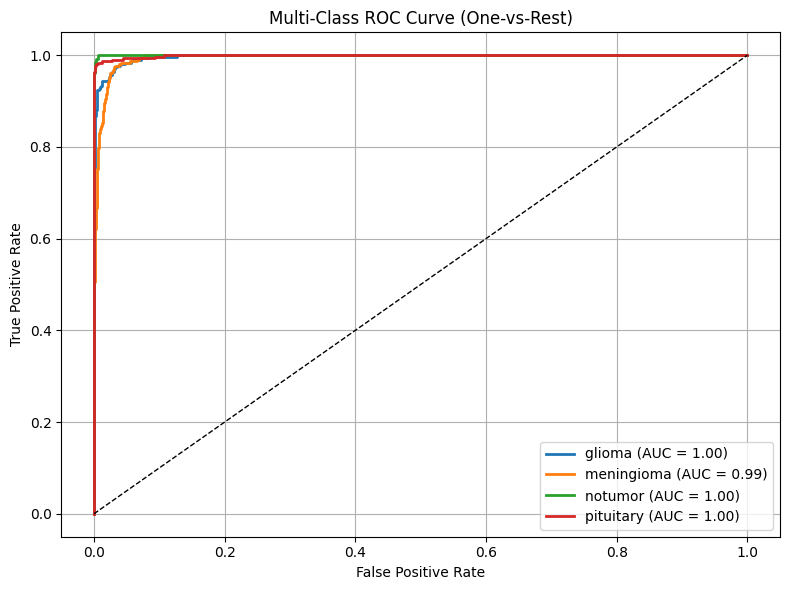

In [15]:
#plotting roc curve (looking at performance of our model for every class)

 
# ===============================
# Imports
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# ===============================
# Assumptions
# ===============================
# test_predictions : model.predict(test_images)
# shape -> (num_samples, num_classes)
# test_labels_encoded : true labels as integers (0,1,2,3)

num_classes = test_predictions.shape[1]

# ===============================
# Binarize labels (One-vs-Rest)
# ===============================
test_labels_bin = label_binarize(
    test_labels_encoded,
    classes=list(range(num_classes))
)

# ===============================
# Compute ROC & AUC
# ===============================
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(
        test_labels_bin[:, i],
        test_predictions[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# ===============================
# Class names (adjust if needed)
# ===============================
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# ===============================
# Plot ROC Curves
# ===============================
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        linewidth=2,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

# Random classifier reference line
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




In [16]:
model.save("brain_tumor_model.keras")


In [17]:
from tensorflow.keras.models import load_model

#load the trained model

model = load_model("brain_tumor_model.keras")

In [30]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = sorted(os.listdir(train_dir))

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


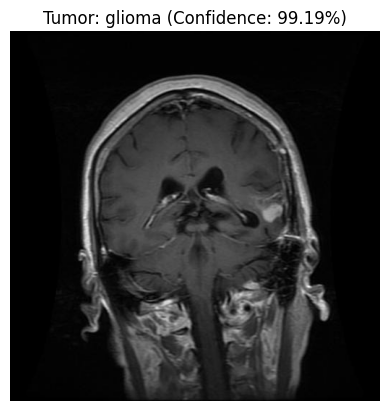

In [31]:
# Example usage
image_path = 'MRI_images/Training/glioma/Tr-gl_0016.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)